# 1. Introduction and Setup

## Customer Personality Analysis

This is a simple practice on cleaning and analyzing data. This dataset is from Kaggle (https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis?resource=download)

### Relevant Information
#### Context
##### Problem Statement

Customer Personality Analysis is a detailed analysis of a company’s ideal customers. It helps a business to better understand its customers and makes it easier for them to modify products according to the specific needs, behaviors and concerns of different types of customers.

Customer personality analysis helps a business to modify its product based on its target customers from different types of customer segments. For example, instead of spending money to market a new product to every customer in the company’s database, a company can analyze which customer segment is most likely to buy the product and then market the product only on that particular segment.

#### Content
##### Attributes

###### People

- ID: Customer's unique identifier
- Year_Birth: Customer's birth year
- Education: Customer's education level
- Marital_Status: Customer's marital status
- Income: Customer's yearly household income
- Kidhome: Number of children in customer's household
- Teenhome: Number of teenagers in customer's household
- Dt_Customer: Date of customer's enrollment with the company
- Recency: Number of days since customer's last purchase
- Complain: 1 if the customer complained in the last 2 years, 0 otherwise

###### Products

- MntWines: Amount spent on wine in last 2 years
- MntFruits: Amount spent on fruits in last 2 years
- MntMeatProducts: Amount spent on meat in last 2 years
- MntFishProducts: Amount spent on fish in last 2 years
- MntSweetProducts: Amount spent on sweets in last 2 years
- MntGoldProds: Amount spent on gold in last 2 years

###### Promotion

- NumDealsPurchases: Number of purchases made with a discount
- AcceptedCmp1: 1 if customer accepted the offer in the 1st campaign, 0 otherwise
- AcceptedCmp2: 1 if customer accepted the offer in the 2nd campaign, 0 otherwise
- AcceptedCmp3: 1 if customer accepted the offer in the 3rd campaign, 0 otherwise
- AcceptedCmp4: 1 if customer accepted the offer in the 4th campaign, 0 otherwise
- AcceptedCmp5: 1 if customer accepted the offer in the 5th campaign, 0 otherwise
- Response: 1 if customer accepted the offer in the last campaign, 0 otherwise

###### Place

- NumWebPurchases: Number of purchases made through the company’s website
- NumCatalogPurchases: Number of purchases made using a catalogue
- NumStorePurchases: Number of purchases made directly in stores
- NumWebVisitsMonth: Number of visits to company’s website in the last month

## Library Imports and Configuration

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Loading Data 

In [27]:
# load dataset
data = pd.read_csv('data/marketing_campaign.csv', sep='\t')
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


# 2. Exploratory Data Analysis

## Structural Inspection

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [29]:
data.describe()

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
count,2240.000000,2240.000000,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,...,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.0,2240.0,2240.000000
mean,5592.159821,1968.805804,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,...,5.316518,0.072768,0.074554,0.072768,0.064286,0.013393,0.009375,3.0,11.0,0.149107
std,3246.662198,11.984069,25173.076661,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,...,2.426645,0.259813,0.262728,0.259813,0.245316,0.114976,0.096391,0.0,0.0,0.356274
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
25%,2828.250000,1959.000000,35303.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
50%,5458.500000,1970.000000,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,...,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
75%,8427.750000,1977.000000,68522.000000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,...,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
max,11191.000000,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,...,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0,11.0,1.000000


In [30]:
data.isin([np.inf, -np.inf]).any()

ID                     False
Year_Birth             False
Education              False
Marital_Status         False
Income                 False
Kidhome                False
Teenhome               False
Dt_Customer            False
Recency                False
MntWines               False
MntFruits              False
MntMeatProducts        False
MntFishProducts        False
MntSweetProducts       False
MntGoldProds           False
NumDealsPurchases      False
NumWebPurchases        False
NumCatalogPurchases    False
NumStorePurchases      False
NumWebVisitsMonth      False
AcceptedCmp3           False
AcceptedCmp4           False
AcceptedCmp5           False
AcceptedCmp1           False
AcceptedCmp2           False
Complain               False
Z_CostContact          False
Z_Revenue              False
Response               False
dtype: bool

In [31]:
data.duplicated().any()

np.False_

In [32]:
type(data['Dt_Customer'][0])

str

## Basic Data Cleaning

We noticed the following aspects:
- **Dt_Customer** is a string; convert it to datetime format.
- **Income** has missing values.
- Later, for using a machine learning algorithm and others, we need to convert **Education**, **Marital_Status** and the same **Dt_Customer**

### Converting Dt_Customer

In [33]:
cleaned_data = data.copy()
cleaned_data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'], format='%d-%m-%Y')
cleaned_data['Dt_Customer'].head()

0   2012-09-04
1   2014-03-08
2   2013-08-21
3   2014-02-10
4   2014-01-19
Name: Dt_Customer, dtype: datetime64[ns]

In [36]:
cleaned_data['Dt_Customer'].describe()

count                             2240
mean     2013-07-10 10:01:42.857142784
min                2012-07-30 00:00:00
25%                2013-01-16 00:00:00
50%                2013-07-08 12:00:00
75%                2013-12-30 06:00:00
max                2014-06-29 00:00:00
Name: Dt_Customer, dtype: object

### Deleting rows with None Values

This decision is based on the fact that Income is a fundamental feature, and the dataset only has 24 rows with missing values.

In [38]:
cleaned_data.dropna(inplace=True)
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2216 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   2216 non-null   int64         
 1   Year_Birth           2216 non-null   int64         
 2   Education            2216 non-null   object        
 3   Marital_Status       2216 non-null   object        
 4   Income               2216 non-null   float64       
 5   Kidhome              2216 non-null   int64         
 6   Teenhome             2216 non-null   int64         
 7   Dt_Customer          2216 non-null   datetime64[ns]
 8   Recency              2216 non-null   int64         
 9   MntWines             2216 non-null   int64         
 10  MntFruits            2216 non-null   int64         
 11  MntMeatProducts      2216 non-null   int64         
 12  MntFishProducts      2216 non-null   int64         
 13  MntSweetProducts     2216 non-null   i

## Univariate Analysis

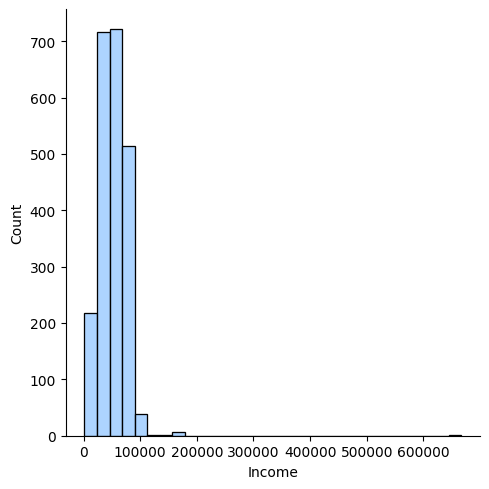

In [48]:
plt.style.use('seaborn-v0_8-pastel')

sns.displot(
    data=cleaned_data,
    x='Income',
    bins=30,
)

plt.show()

## Multivariate Analysis

In [43]:
# Analyzing object type columns
for col in cleaned_data.select_dtypes(include=['object']).columns:
    print(f'{col}: {cleaned_data[col].unique()}')

Education: ['Graduation' 'PhD' 'Master' 'Basic' '2n Cycle']
Marital_Status: ['Single' 'Together' 'Married' 'Divorced' 'Widow' 'Alone' 'Absurd' 'YOLO']


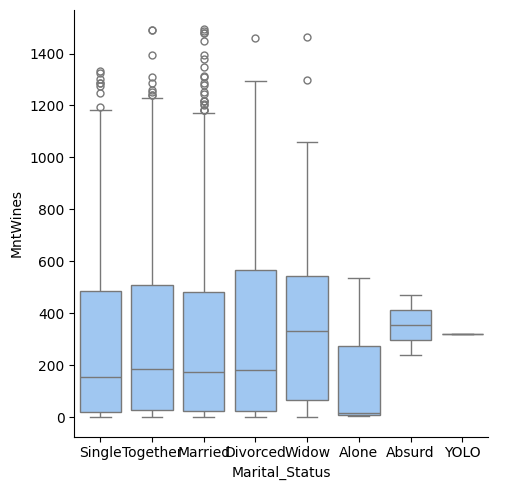

In [59]:
sns.catplot(
    data=cleaned_data,
    kind='box',
    x='Marital_Status',
    y='MntWines',
)

# sns.displot(
#     data=cleaned_data,
#     x='MntFruits',
#     hue='Marital_Status',
#     multiple='stack',
#     bins=30,
# )

plt.show()

## Problem Identification

# 3. Data Preprocessing and Feature Engineering

## Data Cleaning

## Feature Engineering

## Variable Encoding and Scaling

## Data Splitting

# 4. Modeling and Evaluation

# 5. Interpretation and Conclusion